# Count Lines Per Protagonist

This notebook counts the number of lines per character in each movie and keeps only the character with the most lines (the first one if there are ties).

In [1]:
import pandas as pd
import os
from pathlib import Path

In [2]:
import pandas as pd
import os
from pathlib import Path

# Path to the movie character texts directory
base_path = Path("data/movie_characters/data/movie_character_texts/movie_character_texts")

# List to store results
results = []

# Iterate through each movie directory
for movie_dir in sorted(base_path.iterdir()):
    if movie_dir.is_dir():
        # Extract movie name and IMDB ID
        movie_name_id = movie_dir.name
        parts = movie_name_id.rsplit('_', 1)
        if len(parts) == 2:
            movie_name = parts[0]
            imdb_id = parts[1]
        else:
            movie_name = movie_name_id
            imdb_id = ""
        
        # Iterate through each character file in the movie directory
        for character_file in movie_dir.glob("*_text.txt"):
            # Extract character name (remove '_text.txt' suffix)
            character_name = character_file.stem.replace('_text', '')
            
            # Count lines in the file
            with open(character_file, 'r', encoding='utf-8', errors='ignore') as f:
                lines = f.readlines()
                line_count = len(lines)
            
            # Add to results
            results.append({
                'movie_name': movie_name,
                'imdb_id': imdb_id,
                'character_name': character_name,
                'line_count': line_count
            })

# Create DataFrame
movie_data = pd.DataFrame(results)

# Keep only the first character with the most lines per movie (no ties)
movie_data = movie_data.loc[movie_data.groupby('movie_name')['line_count'].idxmax()].copy()

# Load movie metadata
metadata_df = pd.read_csv("data/movie_metadata/movie_meta_data.csv")
metadata_df = metadata_df[['imdbid', 'title', 'directors', 'genres', 'imdb user rating']].copy()
metadata_df.columns = ['imdb_id', 'title', 'director', 'genres', 'imdb_rating']

# Merge protagonist data with movie metadata
movie_data['imdb_id_padded'] = movie_data['imdb_id'].astype(str).str.zfill(7)
metadata_df['imdb_id_padded'] = metadata_df['imdb_id'].astype(str).str.zfill(7)
movie_data = movie_data.merge(
    metadata_df, 
    left_on='imdb_id_padded',
    right_on='imdb_id_padded',
    how='left',
    suffixes=('', '_meta')
)
movie_data = movie_data.drop(columns=['imdb_id_padded', 'imdb_id_meta'], errors='ignore')

# Add column with path to full script
movie_data['script_filename'] = movie_data['movie_name'] + '_' + movie_data['imdb_id'] + '.txt'
movie_data['script_path'] = 'data/screenplay_data/data/raw_texts/raw_texts/' + movie_data['script_filename']
movie_data['script_exists'] = movie_data['script_path'].apply(lambda x: os.path.exists(x))

# Remove rows where script files are missing
movie_data = movie_data[movie_data['script_exists']].copy()

# Save the final DataFrame to CSV
output_path = "protagonist_line_counts.csv"
movie_data.to_csv(output_path, index=False)
print(f"Final DataFrame saved to: {output_path}")

# Display summary
print(f"Remaining movies with scripts: {movie_data['movie_name'].nunique()}")
print(f"Remaining rows: {movie_data.shape[0]}")
print(movie_data.head())

Final DataFrame saved to: protagonist_line_counts.csv
Remaining movies with scripts: 2138
Remaining rows: 2138
                   movie_name  imdb_id   character_name  line_count  \
0         10 Cloverfield Lane  1179933           Howard         316   
1  10 Things I Hate About You  0147800    Kat Stratford         387   
2                12 Angry Men  0118528          Foreman          98   
3                  12 Monkeys  0114746   Jeffrey Goines          97   
4            12 Years a Slave  2024544  Solomon Northup         289   

                        title          director  \
0         10 Cloverfield Lane  Dan Trachtenberg   
1  10 Things I Hate About You        Gil Junger   
2                12 Angry Men  William Friedkin   
3                  12 Monkeys     Terry Gilliam   
4            12 Years a Slave     Steve McQueen   

                                             genres  imdb_rating  \
0  Action, Drama, Horror, Mystery, Sci-Fi, Thriller            7   
1                  

In [3]:
# Display first few rows
movie_data.head(10)

,movie_name,imdb_id,character_name,line_count,title,director,genres,imdb_rating,script_filename,script_path,script_exists
0,10 Cloverfield Lane,1179933,Howard,316,10 Cloverfield Lane,Dan Trachtenberg,"Action, Drama, Horror, Mystery, Sci-Fi, Thriller",7,10 Cloverfield Lane_1179933.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True
1,10 Things I Hate About You,0147800,Kat Stratford,387,10 Things I Hate About You,Gil Junger,"Comedy, Drama, Romance",7,10 Things I Hate About You_0147800.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True
2,12 Angry Men,0118528,Foreman,98,12 Angry Men,William Friedkin,"Crime, Drama",7,12 Angry Men_0118528.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True
3,12 Monkeys,0114746,Jeffrey Goines,97,12 Monkeys,Terry Gilliam,"Mystery, Sci-Fi, Thriller",8,12 Monkeys_0114746.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True
4,12 Years a Slave,2024544,Solomon Northup,289,12 Years a Slave,Steve McQueen,"Biography, Drama, History",8,12 Years a Slave_2024544.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True
5,127 Hours,1542344,Aron Ralston,183,127 Hours,Danny Boyle,"Biography, Drama",7,127 Hours_1542344.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True
6,13 13 13,2991516,Jack,362,13/13/13,James Cullen Bressack,Horror,3,13 13 13_2991516.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True
7,1408,0450385,Mike Enslin,445,1408,Mikael Håfström,"Fantasy, Horror, Mystery",6,1408_0450385.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True
8,1492 Conquest of Paradise,0103594,Columbus,488,1492: Conquest of Paradise,Ridley Scott,"Adventure, Biography, Drama, History",6,1492 Conquest of Paradise_0103594.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True
9,15 Minutes,0179626,Emil Slovak,188,15 Minutes,John Herzfeld,"Action, Crime, Drama, Thriller",6,15 Minutes_0179626.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True


In [4]:
# Display sample of protagonists
movie_data.tail(20)

,movie_name,imdb_id,character_name,line_count,title,director,genres,imdb_rating,script_filename,script_path,script_exists
2119,X Men Origins Wolverine,0458525,Logan Wolverine,189,X-Men Origins: Wolverine,Gavin Hood,"Action, Adventure, Sci-Fi",6,X Men Origins Wolverine_0458525.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True
2120,X Men The Animated Series,0103584,Logan,139,X-Men: The Animated Series,NaN,"Animation, Action, Family, Sci-Fi",8,X Men The Animated Series_0103584.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True
2121,X2 X Men United,0290334,Logan Wolverine,118,X2: X-Men United,Bryan Singer,"Action, Adventure, Sci-Fi, Thriller",7,X2 X Men United_0290334.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True
2122,XTRMN8mm,5660414,Agent,4,XTRMN8mm,David Cox,Short,-1,XTRMN8mm_5660414.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True
2123,Y The Last Man,8042500,Yorick Brown,315,Y: The Last Man,NaN,"Action, Drama, Fantasy, Sci-Fi",-1,Y The Last Man_8042500.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True
2124,Yes Man,1068680,Carl,899,Yes Man,Peyton Reed,"Comedy, Romance",6,Yes Man_1068680.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True
2125,You Came Along,0038263,Waiter,2,You Came Along,John Farrow,"Drama, Romance",6,You Came Along_0038263.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True
2126,You Can Count on Me,0203230,Sammy,388,You Can Count on Me,Kenneth Lonergan,Drama,7,You Can Count on Me_0203230.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True
2127,You Only Live Twice,0062512,Man at Typewriter in Office,3,You Only Live Twice,Lewis Gilbert,"Action, Adventure, Thriller",6,You Only Live Twice_0062512.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True
2128,You Were Never Really Here,5742374,Joe,153,You Were Never Really Here,Lynne Ramsay,"Crime, Drama, Mystery, Thriller",6,You Were Never Really Here_5742374.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True


In [5]:
# Summary statistics
print("Summary statistics for protagonist line counts:")
print(movie_data['line_count'].describe())

Summary statistics for protagonist line counts:
count    2138.000000
mean      267.449018
std       171.071728
min         1.000000
25%       131.250000
50%       260.000000
75%       375.000000
max      1017.000000
Name: line_count, dtype: float64


In [6]:
# Load movie metadata
metadata_df = pd.read_csv("data/movie_metadata/movie_meta_data.csv")

# Select relevant columns
metadata_df = metadata_df[['imdbid', 'title', 'directors', 'genres', 'imdb user rating']].copy()

# Rename columns for clarity
metadata_df.columns = ['imdb_id', 'title', 'director', 'genres', 'imdb_rating']

print(f"Metadata shape: {metadata_df.shape}")
print(f"\nMetadata sample:")
metadata_df.head()

Metadata shape: (2858, 5)

Metadata sample:


,imdb_id,title,director,genres,imdb_rating
0,120770,A Night at the Roxbury,John Fortenberry,"Comedy, Music, Romance",6
1,132512,At First Sight,Irwin Winkler,"Drama, Romance",6
2,118661,The Avengers,Jeremiah S. Chechik,"Action, Adventure, Sci-Fi, Thriller",3
3,215545,Bamboozled,Spike Lee,"Comedy, Drama, Music",6
4,118715,The Big Lebowski,"Joel Coen, Ethan Coen","Comedy, Crime, Sport",8


In [7]:
# Merge protagonist data with movie metadata
# Convert imdb_id to string and pad with leading zeros to 7 digits for consistent format
movie_data['imdb_id_padded'] = movie_data['imdb_id'].astype(str).str.zfill(7)
metadata_df['imdb_id_padded'] = metadata_df['imdb_id'].astype(str).str.zfill(7)

# Merge on the padded imdb_id
movie_data = movie_data.merge(
    metadata_df, 
    left_on='imdb_id_padded',
    right_on='imdb_id_padded',
    how='left',
    suffixes=('', '_meta')
)

# Drop the temporary padded column and the duplicate imdb_id from metadata
movie_data = movie_data.drop(columns=['imdb_id_padded', 'imdb_id_meta'], errors='ignore')

print(f"Merged DataFrame shape: {movie_data.shape}")
print(f"\nMerge statistics:")
print(f"  - Protagonists matched with metadata: {movie_data['title'].notna().sum()}")
print(f"  - Protagonists without metadata: {movie_data['title'].isna().sum()}")

movie_data.head(10)

Merged DataFrame shape: (2138, 15)

Merge statistics:
  - Protagonists matched with metadata: 2138
  - Protagonists without metadata: 0


,movie_name,imdb_id,character_name,line_count,title,director,genres,imdb_rating,script_filename,script_path,script_exists,title_meta,director_meta,genres_meta,imdb_rating_meta
0,10 Cloverfield Lane,1179933,Howard,316,10 Cloverfield Lane,Dan Trachtenberg,"Action, Drama, Horror, Mystery, Sci-Fi, Thriller",7,10 Cloverfield Lane_1179933.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True,10 Cloverfield Lane,Dan Trachtenberg,"Action, Drama, Horror, Mystery, Sci-Fi, Thriller",7
1,10 Things I Hate About You,0147800,Kat Stratford,387,10 Things I Hate About You,Gil Junger,"Comedy, Drama, Romance",7,10 Things I Hate About You_0147800.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True,10 Things I Hate About You,Gil Junger,"Comedy, Drama, Romance",7
2,12 Angry Men,0118528,Foreman,98,12 Angry Men,William Friedkin,"Crime, Drama",7,12 Angry Men_0118528.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True,12 Angry Men,William Friedkin,"Crime, Drama",7
3,12 Monkeys,0114746,Jeffrey Goines,97,12 Monkeys,Terry Gilliam,"Mystery, Sci-Fi, Thriller",8,12 Monkeys_0114746.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True,12 Monkeys,Terry Gilliam,"Mystery, Sci-Fi, Thriller",8
4,12 Years a Slave,2024544,Solomon Northup,289,12 Years a Slave,Steve McQueen,"Biography, Drama, History",8,12 Years a Slave_2024544.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True,12 Years a Slave,Steve McQueen,"Biography, Drama, History",8
5,127 Hours,1542344,Aron Ralston,183,127 Hours,Danny Boyle,"Biography, Drama",7,127 Hours_1542344.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True,127 Hours,Danny Boyle,"Biography, Drama",7
6,13 13 13,2991516,Jack,362,13/13/13,James Cullen Bressack,Horror,3,13 13 13_2991516.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True,13/13/13,James Cullen Bressack,Horror,3
7,1408,0450385,Mike Enslin,445,1408,Mikael Håfström,"Fantasy, Horror, Mystery",6,1408_0450385.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True,1408,Mikael Håfström,"Fantasy, Horror, Mystery",6
8,1492 Conquest of Paradise,0103594,Columbus,488,1492: Conquest of Paradise,Ridley Scott,"Adventure, Biography, Drama, History",6,1492 Conquest of Paradise_0103594.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True,1492: Conquest of Paradise,Ridley Scott,"Adventure, Biography, Drama, History",6
9,15 Minutes,0179626,Emil Slovak,188,15 Minutes,John Herzfeld,"Action, Crime, Drama, Thriller",6,15 Minutes_0179626.txt,data/screenplay_data/data/raw_texts/raw_texts/...,True,15 Minutes,John Herzfeld,"Action, Crime, Drama, Thriller",6


In [8]:
# Add column with path to full script
import os

# Create the script file path by combining movie_name and imdb_id
movie_data['script_filename'] = movie_data['movie_name'] + '_' + movie_data['imdb_id'] + '.txt'
movie_data['script_path'] = 'data/screenplay_data/data/raw_texts/raw_texts/' + movie_data['script_filename']

# Check if the script files actually exist
movie_data['script_exists'] = movie_data['script_path'].apply(
    lambda x: os.path.exists(x)
)

print(f"Scripts found: {movie_data['script_exists'].sum()}")
print(f"Scripts not found: {(~movie_data['script_exists']).sum()}")

# Show some examples
print("\nExamples with scripts:")
print(movie_data[movie_data['script_exists']][['movie_name', 'character_name', 'script_path']].head(5))

print("\nExamples without scripts:")
print(movie_data[~movie_data['script_exists']][['movie_name', 'character_name', 'script_filename']].head(5))

Scripts found: 2138
Scripts not found: 0

Examples with scripts:
                   movie_name   character_name  \
0         10 Cloverfield Lane           Howard   
1  10 Things I Hate About You    Kat Stratford   
2                12 Angry Men          Foreman   
3                  12 Monkeys   Jeffrey Goines   
4            12 Years a Slave  Solomon Northup   

                                         script_path  
0  data/screenplay_data/data/raw_texts/raw_texts/...  
1  data/screenplay_data/data/raw_texts/raw_texts/...  
2  data/screenplay_data/data/raw_texts/raw_texts/...  
3  data/screenplay_data/data/raw_texts/raw_texts/...  
4  data/screenplay_data/data/raw_texts/raw_texts/...  

Examples without scripts:
Empty DataFrame
Columns: [movie_name, character_name, script_filename]
Index: []


In [9]:
# Remove rows where script files are missing
movie_data = movie_data[movie_data['script_exists']].copy()

print(f"Remaining movies with scripts: {movie_data['movie_name'].nunique()}")
print(f"Remaining rows: {movie_data.shape[0]}")

Remaining movies with scripts: 2138
Remaining rows: 2138


In [10]:
# Loop over rows and print the beginning of every thousandth script
for idx, row in movie_data.iterrows():
    if idx % 1000 == 0:
        script_path = row['script_path']
        try:
            with open(script_path, 'r', encoding='utf-8', errors='ignore') as f:
                print(f"Script {idx}: {script_path}")
                print(f.read(100))  # Print the first 100 characters of the script
        except FileNotFoundError:
            print(f"Script not found: {script_path}")

Script 0: data/screenplay_data/data/raw_texts/raw_texts/10 Cloverfield Lane_1179933.txt
The Cellar

by
Josh Campbell & Matt Stuecken
DARKNESS

And then --

A GUNNED ENGINE --

BLURRED HEA
Script 1000: data/screenplay_data/data/raw_texts/raw_texts/McCabe Mrs Miller_0067411.txt
 

 

FOR EDUCATIONAL

 

 

PURPOSES ONLY

1.

2.

Mc CARE + MRS. MILLER

OTHE PRESBYTERIAN CHURCH 
Script 2000: data/screenplay_data/data/raw_texts/raw_texts/Trainwreck_3152624.txt
PRODUCER: Judd Apatow
PRODUCER: Barry Mendel
EXECUTIVE PRODUCER: David Householter

TRAINWRECK

by
A


In [13]:
# Dummy code genres and keep the 12 most common genres
genre_dummies = movie_data['genres'].str.get_dummies(sep=', ')

# Sum up occurrences of each genre and keep the top 12
most_common_genres = genre_dummies.sum().nlargest(12).index
filtered_genres = genre_dummies[most_common_genres]

# Add the filtered genres back to the main DataFrame
movie_data = pd.concat([movie_data, filtered_genres], axis=1)

print("Top 12 genres added as dummy variables:")
print(filtered_genres.columns)

Top 12 genres added as dummy variables:
Index(['Drama', 'Thriller', 'Comedy', 'Action', 'Crime', 'Romance',
       'Adventure', 'Sci-Fi', 'Mystery', 'Horror', 'Fantasy', 'Biography'],
      dtype='object')


<Axes: >

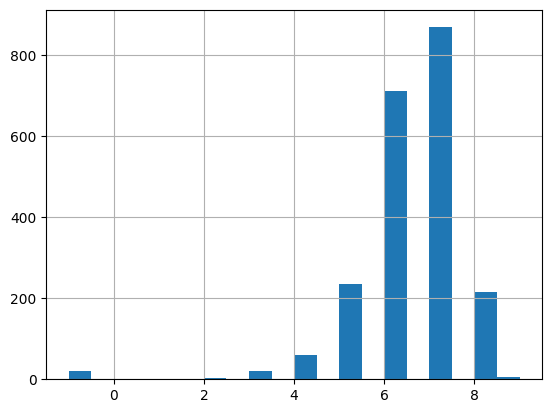

In [19]:
movie_data.head(10) 
import matplotlib.pyplot as plt
movie_data.imdb_rating.hist(bins=20)